# Recommendation Engine for E-Commerce Sales

This tutorial gives an overview of techniques and services offer by SageMaker to build and deploy a personalized recommendation engine.

## Setup

In [ ]:
# install tree command (helpful in printing folder structures)
!apt-get install tree

# setup AWS cli
!mkdir -p ~/.aws && cp /content/drive/MyDrive/AWS/d01_admin/* ~/.aws
!chmod 600 ~/.aws/credentials
!pip install awscli

# install boto3 and sagemaker
!pip install boto3
!pip install sagemaker

# install dependencies
!pip install pyathena
!pip install awswrangler
!pip install smclarify
!pip install sagemaker-experiments
!pip install sagemaker-tensorflow
!pip install smclarify
!pip install stepfunctions

# install nlp libs
!pip install transformers

In [19]:
# imports
import boto3
import sagemaker
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import io
import os
import sys
import time
import datetime
import json
import csv

from scipy.sparse import csr_matrix, hstack, save_npz, load_npz
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import sagemaker.amazon.common as smac
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import JSONSerializer
from sagemaker.multidatamodel import MultiDataModel
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.lineage import context, artifact, association, action

In [2]:
# global variables
role = "sagemakerRole"
prefix = "sagemaker-exp11061740"
training_instance_type = "ml.m5.xlarge"

In [3]:
# setup sagemaker session
sess = sagemaker.Session()
bucket = sess.default_bucket()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")
role_arn = "arn:aws:iam::{}:role/{}".format(account_id, role)
sm = boto3.Session().client(service_name="sagemaker", region_name=region)
s3 = boto3.Session().client(service_name="s3", region_name=region)
runtime = boto3.Session().client(service_name='runtime.sagemaker')
runtime_sm_client = boto3.client('sagemaker-runtime')

## Data Ingest

In [4]:
!wget -q --show-progress https://github.com/RecoHut-Datasets/retail_session/raw/main/Online%20Retail.csv

Online Retail.csv   100%[===================>]  45.81M   190MB/s    in 0.2s    


The dataset for this demo comes from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Online+Retail). It contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. The following attributes are included in our dataset:
+ InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
+ StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
+ Description: Product (item) name. Nominal.
+ Quantity: The quantities of each product (item) per transaction. Numeric.
+ InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
+ UnitPrice: Unit price. Numeric, Product price per unit in sterling.
+ CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
+ Country: Country name. Nominal, the name of the country where each customer resides. 

Citation: Daqing Chen, Sai Liang Sain, and Kun Guo, Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining, Journal of Database Marketing and Customer Strategy Management, Vol. 19, No. 3, pp. 197â€“208, 2012 (Published online before print: 27 August 2012. doi: 10.1057/dbm.2012.17)

In [6]:
df = pd.read_csv("Online Retail.csv")
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


## Data Prepare

In [7]:
# Drop any records with a missing CustomerID. If we do not know who 
# the customer is, then it is not helpful to us when we make recommendations
df.dropna(subset=["CustomerID"], inplace=True)
df["Description"] = df["Description"].apply(lambda x: x.strip())
print(df.shape)

(406829, 8)


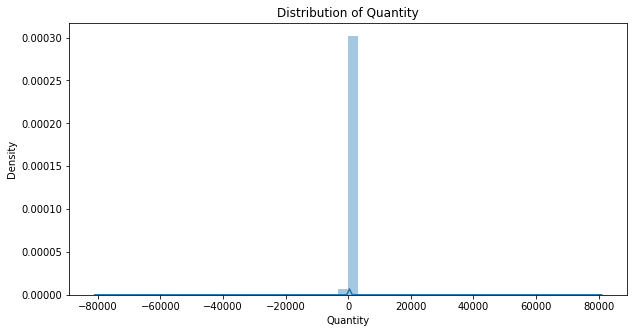

In [8]:
plt.figure(figsize=(10, 5))
sns.distplot(df["Quantity"], kde=True)
plt.title("Distribution of Quantity")
plt.xlabel("Quantity");

Most of our quantities are realteively small (positive) numbers, but there are also some negative quantities as well as extreme outliers (both postiive and negative outliers).

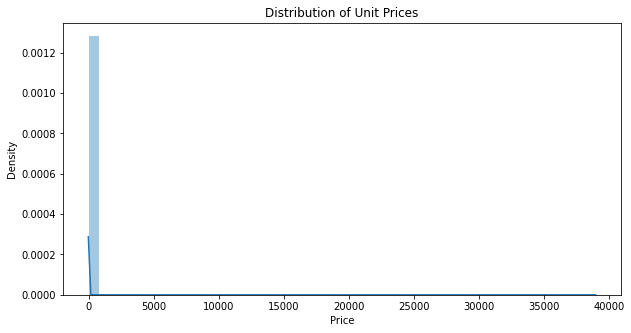

In [9]:
plt.figure(figsize=(10, 5))
sns.distplot(df["UnitPrice"], kde=True)
plt.title("Distribution of Unit Prices")
plt.xlabel("Price");

There are no negative prices, which is good, but we can see some extreme outliers.

In [10]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [11]:
df = df.groupby(["StockCode", "Description", "CustomerID", "Country", "UnitPrice"])[
    "Quantity"
].sum()
df = df.loc[df > 0].reset_index()
df.shape

(274399, 6)

In [12]:
def loadDataset(dataframe):
    enc = OneHotEncoder(handle_unknown="ignore")
    onehot_cols = ["StockCode", "CustomerID", "Country"]
    ohe_output = enc.fit_transform(dataframe[onehot_cols])

    vectorizer = TfidfVectorizer(min_df=2)
    unique_descriptions = dataframe["Description"].unique()
    vectorizer.fit(unique_descriptions)
    tfidf_output = vectorizer.transform(dataframe["Description"])

    row = range(len(dataframe))
    col = [0] * len(dataframe)
    unit_price = csr_matrix((dataframe["UnitPrice"].values, (row, col)), dtype="float32")

    X = hstack([ohe_output, tfidf_output, unit_price], format="csr", dtype="float32")
    y = dataframe["Quantity"].values.astype("float32")

    return X, y

In [13]:
X, y = loadDataset(df)

In [14]:
# display sparsity
total_cells = X.shape[0] * X.shape[1]
(total_cells - X.nnz) / total_cells

0.9991284988048746

Our data is over 99.9% sparse. Because of this high sparsity, the sparse matrix data type allows us to represent our data using only a small fraction of the memory that a dense matrix would require.

In [15]:
# Prepare Data For Modeling
# 1. Split the data into training and testing sets
# 2. Write the data to protobuf recordIO format for Pipe mode.
# [Read more](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html) 
# about protobuf recordIO format.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

df.to_csv("online_retail_preprocessed.csv", index=False)
save_npz("X_train.npz", X_train)
save_npz("X_test.npz", X_test)
np.savez("y_train.npz", y_train)
np.savez("y_test.npz", y_test)

In [16]:
train_key = "train.protobuf"
train_prefix = f"{prefix}/train"

test_key = "test.protobuf"
test_prefix = f"{prefix}/test"

output_prefix = f"s3://{bucket}/{prefix}/output"

In [17]:
def writeDatasetToProtobuf(X, y, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, y)
    buf.seek(0)
    obj = "{}/{}".format(prefix, key)
    boto3.resource("s3").Bucket(bucket).Object(obj).upload_fileobj(buf)
    return "s3://{}/{}".format(bucket, obj)

In [18]:
train_data_location = writeDatasetToProtobuf(X_train, y_train, bucket, train_prefix, train_key)
test_data_location = writeDatasetToProtobuf(X_test, y_test, bucket, test_prefix, test_key)

print(train_data_location)
print(test_data_location)
print("Output: {}".format(output_prefix))

s3://sagemaker-us-east-1-390354360073/sagemaker-exp11061740/train/train.protobuf
s3://sagemaker-us-east-1-390354360073/sagemaker-exp11061740/test/test.protobuf
Output: s3://sagemaker-us-east-1-390354360073/sagemaker-exp11061740/output


## Model Train

In [22]:
class InferenceSpecification:

    template = """
{    
    "InferenceSpecification": {
        "Containers" : [{"Image": "IMAGE_REPLACE_ME"}],
        "SupportedTransformInstanceTypes": INSTANCES_REPLACE_ME,
        "SupportedRealtimeInferenceInstanceTypes": INSTANCES_REPLACE_ME,
        "SupportedContentTypes": CONTENT_TYPES_REPLACE_ME,
        "SupportedResponseMIMETypes": RESPONSE_MIME_TYPES_REPLACE_ME
    }
}
"""

    def get_inference_specification_dict(
        self, ecr_image, supports_gpu, supported_content_types=None, supported_mime_types=None
    ):
        return json.loads(
            self.get_inference_specification_json(
                ecr_image, supports_gpu, supported_content_types, supported_mime_types
            )
        )

    def get_inference_specification_json(
        self, ecr_image, supports_gpu, supported_content_types=None, supported_mime_types=None
    ):
        if supported_mime_types is None:
            supported_mime_types = []
        if supported_content_types is None:
            supported_content_types = []
        return (
            self.template.replace("IMAGE_REPLACE_ME", ecr_image)
            .replace("INSTANCES_REPLACE_ME", self.get_supported_instances(supports_gpu))
            .replace("CONTENT_TYPES_REPLACE_ME", json.dumps(supported_content_types))
            .replace("RESPONSE_MIME_TYPES_REPLACE_ME", json.dumps(supported_mime_types))
        )

    def get_supported_instances(self, supports_gpu):
        cpu_list = [
            "ml.m4.xlarge",
            "ml.m4.2xlarge",
            "ml.m4.4xlarge",
            "ml.m4.10xlarge",
            "ml.m4.16xlarge",
            "ml.m5.large",
            "ml.m5.xlarge",
            "ml.m5.2xlarge",
            "ml.m5.4xlarge",
            "ml.m5.12xlarge",
            "ml.m5.24xlarge",
            "ml.c4.xlarge",
            "ml.c4.2xlarge",
            "ml.c4.4xlarge",
            "ml.c4.8xlarge",
            "ml.c5.xlarge",
            "ml.c5.2xlarge",
            "ml.c5.4xlarge",
            "ml.c5.9xlarge",
            "ml.c5.18xlarge",
        ]
        gpu_list = [
            "ml.p2.xlarge",
            "ml.p2.8xlarge",
            "ml.p2.16xlarge",
            "ml.p3.2xlarge",
            "ml.p3.8xlarge",
            "ml.p3.16xlarge",
        ]

        list_to_return = cpu_list

        if supports_gpu:
            list_to_return = cpu_list + gpu_list

        return json.dumps(list_to_return)

In [24]:
input_dims = X_train.shape[1]

container = retrieve("factorization-machines", region=region)

fm = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c5.xlarge",
    output_path=output_prefix,
    sagemaker_session=sess,
)

fm.set_hyperparameters(
    feature_dim=input_dims,
    predictor_type="regressor",
    mini_batch_size=1000,
    num_factors=64,
    epochs=20,
)

In [25]:
fm.fit({"train": train_data_location, "test": test_data_location})
training_job_name = fm.latest_training_job.job_name
training_job_name

2022-06-11 12:27:15 Starting - Starting the training job...
2022-06-11 12:27:41 Starting - Preparing the instances for trainingProfilerReport-1654950435: InProgress
......
2022-06-11 12:28:42 Downloading - Downloading input data
2022-06-11 12:28:42 Training - Downloading the training image......
2022-06-11 12:29:42 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
/opt/amazon/lib/python3.7/site-packages/algorithm/network_builder.py:87: DeprecationWarning: invalid escape sequence \s
  """
/opt/amazon/lib/python3.7/site-packages/algorithm/network_builder.py:120: DeprecationWarning: invalid escape seque

'factorization-machines-2022-06-11-12-27-15-178'

## Model Deploy

In [26]:
class FMSerializer(JSONSerializer):
    def serialize(self, data):
        js = {"instances": []}
        for row in data:
            js["instances"].append({"features": row.tolist()})
        return json.dumps(js)


fm_predictor = fm.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    serializer=FMSerializer(),
    deserializer=JSONDeserializer(),
)

---------!

In [27]:
# find customer who spent the most money
df = pd.read_csv("online_retail_preprocessed.csv")

df["invoice_amount"] = df["Quantity"] * df["UnitPrice"]
top_customer = (
    df.groupby("CustomerID").sum()["invoice_amount"].sort_values(ascending=False).index[0]
)

In [28]:
def get_recommendations(df, customer_id, n_recommendations, n_ranks=100):
    popular_items = (
        df.groupby(["StockCode", "UnitPrice"])
        .nunique()["CustomerID"]
        .sort_values(ascending=False)
        .reset_index()
    )
    top_n_items = popular_items["StockCode"].iloc[:n_ranks].values
    top_n_prices = popular_items["UnitPrice"].iloc[:n_ranks].values

    # stock codes can have multiple descriptions, so we will choose whichever description is most common
    item_map = df.groupby("StockCode").agg(lambda x: x.value_counts().index[0])["Description"]

    # find customer's country
    df_subset = df.loc[df["CustomerID"] == customer_id]
    country = df_subset["Country"].value_counts().index[0]

    data = []
    flattened_item_map = [item_map[i] for i in top_n_items]
    for idx in range(len(top_n_items)):
        data.append(
            {
                "StockCode": top_n_items[idx],
                "Description": flattened_item_map[idx],
                "CustomerID": customer_id,
                "Country": country,
                "UnitPrice": top_n_prices[idx],
            }
        )

    df_inference = pd.DataFrame(data)

    # we need to build the data set similar to how we built it for training
    # it should have the same number of features as the training data
    enc = OneHotEncoder(handle_unknown="ignore")
    onehot_cols = ["StockCode", "CustomerID", "Country"]
    enc.fit(df[onehot_cols])
    onehot_output = enc.transform(df_inference[onehot_cols])

    vectorizer = TfidfVectorizer(min_df=2)
    unique_descriptions = df["Description"].unique()
    vectorizer.fit(unique_descriptions)
    tfidf_output = vectorizer.transform(df_inference["Description"])

    row = range(len(df_inference))
    col = [0] * len(df_inference)
    unit_price = csr_matrix((df_inference["UnitPrice"].values, (row, col)), dtype="float32")

    X_inference = hstack([onehot_output, tfidf_output, unit_price], format="csr")

    result = fm_predictor.predict(X_inference.toarray())
    preds = [i["score"] for i in result["predictions"]]
    index_array = np.array(preds).argsort()
    items = enc.inverse_transform(onehot_output)[:, 0]
    top_recs = np.take_along_axis(items, index_array, axis=0)[: -n_recommendations - 1 : -1]
    recommendations = [[i, item_map[i]] for i in top_recs]
    return recommendations

In [29]:
print("Top 5 recommended products:")
get_recommendations(df, top_customer, n_recommendations=5, n_ranks=100)

Top 5 recommended products:


[['22423', 'REGENCY CAKESTAND 3 TIER'],
 ['22776', 'SWEETHEART CAKESTAND 3 TIER'],
 ['22624', 'IVORY KITCHEN SCALES'],
 ['85123A', 'WHITE HANGING HEART T-LIGHT HOLDER'],
 ['85099B', 'JUMBO BAG RED RETROSPOT']]

## Model Register

Once a useful model has been trained, you have the option to register the model for future reference and possible deployment. To do so, we must first properly associate the artifacts of the model.

In [30]:
# Training data artifact
training_job_info = sm.describe_training_job(TrainingJobName=training_job_name)

training_data_s3_uri = training_job_info["InputDataConfig"][0]["DataSource"]["S3DataSource"][
    "S3Uri"
]

matching_artifacts = list(
    artifact.Artifact.list(source_uri=training_data_s3_uri, sagemaker_session=sess)
)

if matching_artifacts:
    training_data_artifact = matching_artifacts[0]
    print(f"Using existing artifact: {training_data_artifact.artifact_arn}")
else:
    training_data_artifact = artifact.Artifact.create(
        artifact_name="TrainingData",
        source_uri=training_data_s3_uri,
        artifact_type="Dataset",
        sagemaker_session=sess,
    )
    print(f"Create artifact {training_data_artifact.artifact_arn}: SUCCESSFUL")

Using existing artifact: arn:aws:sagemaker:us-east-1:390354360073:artifact/44e5238f8073050521066d9bf6c39bf2


In [31]:
# Code artifact
'''We do not need a code artifact because we are using a built-in SageMaker 
Algorithm called Factorization Machines. The Factorization Machines container 
contains all of the code and, by default, our model training stores the 
Factorization Machines image for tracking purposes.'''

'We do not need a code artifact because we are using a built-in SageMaker \nAlgorithm called Factorization Machines. The Factorization Machines container \ncontains all of the code and, by default, our model training stores the \nFactorization Machines image for tracking purposes.'

In [32]:
# Model artifact
trained_model_s3_uri = training_job_info["ModelArtifacts"]["S3ModelArtifacts"]

matching_artifacts = list(
    artifact.Artifact.list(source_uri=trained_model_s3_uri, sagemaker_session=sess)
)

if matching_artifacts:
    model_artifact = matching_artifacts[0]
    print(f"Using existing artifact: {model_artifact.artifact_arn}")
else:
    model_artifact = artifact.Artifact.create(
        artifact_name="TrainedModel",
        source_uri=trained_model_s3_uri,
        artifact_type="Model",
        sagemaker_session=sess,
    )
    print(f"Create artifact {model_artifact.artifact_arn}: SUCCESSFUL")

Using existing artifact: arn:aws:sagemaker:us-east-1:390354360073:artifact/14663e69b31132ce9801be20fb16ef2a


In [33]:
# Set artifact associations
trial_component = sm.describe_trial_component(
    TrialComponentName=training_job_name + "-aws-training-job"
)
trial_component_arn = trial_component["TrialComponentArn"]

In [34]:
# Store artifacts
artifact_list = [[training_data_artifact, "ContributedTo"], [model_artifact, "Produced"]]

for art, assoc in artifact_list:
    try:
        association.Association.create(
            source_arn=art.artifact_arn,
            destination_arn=trial_component_arn,
            association_type=assoc,
            sagemaker_session=sess,
        )
        print(f"Association with {art.artifact_type}: SUCCEESFUL")
    except:
        print(f"Association already exists with {art.artifact_type}")

model_name = "retail-recommendations"
model_matches = sm.list_models(NameContains=model_name)["Models"]

if not model_matches:
    print(f"Creating model {model_name}")
    model = sess.create_model_from_job(
        name=model_name,
        training_job_name=training_job_info["TrainingJobName"],
        role=role,
        image_uri=training_job_info["AlgorithmSpecification"]["TrainingImage"],
    )
else:
    print(f"Model {model_name} already exists.")

Association already exists with DataSet
Association with Model: SUCCEESFUL
Creating model retail-recommendations


In [35]:
# Create Model Package Group
'''After associating all the relevant artifacts, the Model Package Group 
can now be created. A Model Package Groups holds multiple versions or 
iterations of a model. Though it is not required to create them for every
model in the registry, they help organize various models which all have the 
same purpose and provide autiomatic versioning.'''
if "mpg_name" not in locals():
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
    mpg_name = f"retail-recommendation-{timestamp}"

print(f"Model Package Group name: {mpg_name}")

mpg_input_dict = {
    "ModelPackageGroupName": mpg_name,
    "ModelPackageGroupDescription": "Recommendation for Online Retail Sales",
}

matching_mpg = sm.list_model_package_groups(NameContains=mpg_name)[
    "ModelPackageGroupSummaryList"
]

if matching_mpg:
    print(f"Using existing Model Package Group: {mpg_name}")
else:
    mpg_response = sm.create_model_package_group(**mpg_input_dict)
    print(f"Create Model Package Group {mpg_name}: SUCCESSFUL")

model_metrics_report = {"regression_metrics": {}}

for metric in training_job_info["FinalMetricDataList"]:
    stat = {metric["MetricName"]: {"value": metric["Value"]}}
    model_metrics_report["regression_metrics"].update(stat)

with open("training_metrics.json", "w") as f:
    json.dump(model_metrics_report, f)

metrics_s3_key = f"training_jobs/{training_job_info['TrainingJobName']}/training_metrics.json"
s3.upload_file(Filename="training_metrics.json", Bucket=bucket, Key=metrics_s3_key)

Model Package Group name: retail-recommendation-2022-06-11-12-43
Create Model Package Group retail-recommendation-2022-06-11-12-43: SUCCESSFUL


In [36]:
# Define the inference spec
mp_inference_spec = InferenceSpecification().get_inference_specification_dict(
    ecr_image=training_job_info["AlgorithmSpecification"]["TrainingImage"],
    supports_gpu=False,
    supported_content_types=["application/x-recordio-protobuf", "application/json"],
    supported_mime_types=["text/csv"],
)

mp_inference_spec["InferenceSpecification"]["Containers"][0]["ModelDataUrl"] = training_job_info[
    "ModelArtifacts"
]["S3ModelArtifacts"]

In [37]:
# Define model metrics
model_metrics = {
    "ModelQuality": {
        "Statistics": {
            "ContentType": "application/json",
            "S3Uri": f"s3://{bucket}/{metrics_s3_key}",
        }
    }
}
mp_input_dict = {
    "ModelPackageGroupName": mpg_name,
    "ModelPackageDescription": "Factorization Machine Model to create personalized retail recommendations",
    "ModelApprovalStatus": "PendingManualApproval",
    "ModelMetrics": model_metrics,
}

mp_input_dict.update(mp_inference_spec)
mp_response = sm.create_model_package(**mp_input_dict)

In [38]:
# Wait until model package is completed
mp_info = sm.describe_model_package(
    ModelPackageName=mp_response["ModelPackageArn"]
)
mp_status = mp_info["ModelPackageStatus"]

while mp_status not in ["Completed", "Failed"]:
    time.sleep(5)
    mp_info = sm.describe_model_package(
        ModelPackageName=mp_response["ModelPackageArn"]
    )
    mp_status = mp_info["ModelPackageStatus"]
    print(f"model package status: {mp_status}")

print(f"model package status: {mp_status}")

model_package = sm.list_model_packages(ModelPackageGroupName=mpg_name)[
    "ModelPackageSummaryList"
][0]
model_package_update = {
    "ModelPackageArn": model_package["ModelPackageArn"],
    "ModelApprovalStatus": "Approved",
}

update_response = sm.update_model_package(**model_package_update)

model package status: Completed


![](https://drive.google.com/uc?id=1eqm_4uiKORsnsW6pM5ZvRei7zjXIDrua&authuser=recohut.data.001%40gmail.com&usp=drive_fs)

In [39]:
from sagemaker.lineage.visualizer import LineageTableVisualizer

viz = LineageTableVisualizer(sess)
display(viz.show(training_job_name=training_job_name))

,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...2-06-11-12-27-15-178/output/model.tar.gz,Input,Model,Produced,artifact
1,s3://...sagemaker-exp11061740/test/test.protobuf,Input,DataSet,ContributedTo,artifact
2,s3://...gemaker-exp11061740/train/train.protobuf,Input,DataSet,ContributedTo,artifact
3,38241...1.amazonaws.com/factorization-machines:1,Input,Image,ContributedTo,artifact
4,s3://...2-06-11-12-27-15-178/output/model.tar.gz,Output,Model,Produced,artifact


## Pipeline

In [42]:
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.steps import CreateModelStep, ProcessingStep, TrainingStep
from sagemaker.workflow.step_collections import RegisterModel
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.workflow.parameters import ParameterInteger, ParameterFloat, ParameterString

In [41]:
# Define Estimator

'''First, the number of feature dimensions must be calculated as it is 
a hyperparameter of the estimator. The feature dimensions are calculated 
by looking at the dataset, cleaning and preprocessing it as defined in the 
first part of Recommendation Engine for E-Commerce Sales, and then counting 
the number of feature dimensions are in the processed dataset.'''

df = pd.read_csv("Online Retail.csv")
df.dropna(subset=["CustomerID"], inplace=True)
df["Description"] = df["Description"].apply(lambda x: x.strip())
df = df.groupby(["StockCode", "Description", "CustomerID", "Country", "UnitPrice"])[
    "Quantity"
].sum()
df = df.loc[df > 0].reset_index()
X, y = loadDataset(df)
input_dims = X.shape[1]

# After calculating all the hyperparameters that are needed, the estimator is created.

container = sagemaker.image_uris.retrieve("factorization-machines", region=region)

fm = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c5.xlarge",
    output_path=output_prefix,
    sagemaker_session=sess,
)

fm.set_hyperparameters(
    feature_dim=input_dims,
    predictor_type="regressor",
    mini_batch_size=1000,
    num_factors=64,
    epochs=20,
)

In [43]:
%%writefile preprocessing.py
import io
import os
import subprocess
import sys

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

subprocess.check_call([sys.executable, "-m", "pip", "install", "sagemaker"])
import sagemaker.amazon.common as smac


def loadDataset(dataframe):
    enc = OneHotEncoder(handle_unknown="ignore")
    onehot_cols = ["StockCode", "CustomerID", "Country"]
    ohe_output = enc.fit_transform(dataframe[onehot_cols])

    vectorizer = TfidfVectorizer(min_df=2)
    unique_descriptions = dataframe["Description"].unique()
    vectorizer.fit(unique_descriptions)
    tfidf_output = vectorizer.transform(dataframe["Description"])

    row = range(len(dataframe))
    col = [0] * len(dataframe)
    unit_price = csr_matrix((dataframe["UnitPrice"].values, (row, col)), dtype="float32")

    X = hstack([ohe_output, tfidf_output, unit_price], format="csr", dtype="float32")

    y = dataframe["Quantity"].values.astype("float32")

    return X, y


def writeProtobuftoDisk(X, y, fname):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, y)
    buf.seek(0)

    with open(fname, "wb") as f:
        f.write(buf.read())


if __name__ == "__main__":
    base_dir = "/opt/ml/processing"
    df = pd.read_csv(f"{base_dir}/input/Online Retail.csv")

    df.dropna(subset=["CustomerID"], inplace=True)

    df_grouped = df.groupby(["StockCode", "Description", "CustomerID", "Country", "UnitPrice"])[
        "Quantity"
    ].sum()
    df_grouped = df_grouped.loc[df_grouped > 0].reset_index()

    X, y = loadDataset(df_grouped)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    writeProtobuftoDisk(X_train, y_train, f"{base_dir}/output/train/train.protobuf")
    writeProtobuftoDisk(X_test, y_test, f"{base_dir}/output/test/test.protobuf")

#     prefix = 'personalization'

#     train_key      = 'train.protobuf'
#     train_prefix   = f'{prefix}/train'

#     test_key       = 'test.protobuf'
#     test_prefix    = f'{prefix}/test'

#     train_data = writeDatasetToProtobuf(X_train, y_train, bucket, train_prefix, train_key)
#     test_data  = writeDatasetToProtobuf(X_test, y_test, bucket, test_prefix, test_key)

Writing preprocessing.py


In [44]:
%%writefile deploy.py
import argparse
import time

import boto3

# Parse argument variables passed via the DeployModel processing step
parser = argparse.ArgumentParser()
parser.add_argument("--model-name", type=str)
parser.add_argument("--region", type=str)
parser.add_argument("--endpoint-instance-type", type=str)
parser.add_argument("--endpoint-name", type=str)
args = parser.parse_args()

region = args.region
boto3.setup_default_session(region_name=region)
sagemaker_boto_client = boto3.client("sagemaker")

# name truncated per sagameker length requirements (63 char max)
endpoint_config_name = f"{args.model_name[:56]}-config"
existing_configs = sagemaker_boto_client.list_endpoint_configs(NameContains=endpoint_config_name)[
    "EndpointConfigs"
]

if not existing_configs:
    create_ep_config_response = sagemaker_boto_client.create_endpoint_config(
        EndpointConfigName=endpoint_config_name,
        ProductionVariants=[
            {
                "InstanceType": args.endpoint_instance_type,
                "InitialVariantWeight": 1,
                "InitialInstanceCount": 1,
                "ModelName": args.model_name,
                "VariantName": "AllTraffic",
            }
        ],
    )

existing_endpoints = sagemaker_boto_client.list_endpoints(NameContains=args.endpoint_name)[
    "Endpoints"
]

if not existing_endpoints:
    create_endpoint_response = sagemaker_boto_client.create_endpoint(
        EndpointName=args.endpoint_name, EndpointConfigName=endpoint_config_name
    )

endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=args.endpoint_name)
endpoint_status = endpoint_info["EndpointStatus"]

while endpoint_status == "Creating":
    endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=args.endpoint_name)
    endpoint_status = endpoint_info["EndpointStatus"]
    print("Endpoint status:", endpoint_status)
    if endpoint_status == "Creating":
        time.sleep(60)

Writing deploy.py


In [46]:
# Build Pipeline

base_uri = f"s3://{bucket}/data"
input_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path="Online Retail.csv", desired_s3_uri=base_uri
)

input_data = ParameterString(name="InputData", default_value=input_data_uri)

model_approval_status = ParameterString(
    name="ModelApprovalStatus", default_value="PendingManualApproval"
)

create_dataset_script_uri = f"s3://{bucket}/{prefix}/code/preprocessing.py"
s3.upload_file(
    Filename="preprocessing.py", Bucket=bucket, Key=f"{prefix}/code/preprocessing.py"
)

sklearn_processor = SKLearnProcessor(
    framework_version="1.0-1",
    instance_type="ml.m5.xlarge",
    instance_count=1,
    base_job_name="sklearn-retail-sales-process",
    role=role,
)

create_dataset_step = ProcessingStep(
    name="PreprocessData",
    processor=sklearn_processor,
    inputs=[
        sagemaker.processing.ProcessingInput(
            source=input_data, destination="/opt/ml/processing/input"
        ),
    ],
    outputs=[
        sagemaker.processing.ProcessingOutput(
            output_name="train_data", source="/opt/ml/processing/output/train"
        ),
        sagemaker.processing.ProcessingOutput(
            output_name="test_data", source="/opt/ml/processing/output/test"
        ),
    ],
    code=create_dataset_script_uri,
)

train_step = TrainingStep(
    name="TrainingStep",
    estimator=fm,
    inputs={
        "train": sagemaker.inputs.TrainingInput(
            s3_data=create_dataset_step.properties.ProcessingOutputConfig.Outputs[
                "train_data"
            ].S3Output.S3Uri
        ),
        "test": sagemaker.inputs.TrainingInput(
            s3_data=create_dataset_step.properties.ProcessingOutputConfig.Outputs[
                "test_data"
            ].S3Output.S3Uri
        ),
    },
)

model = sagemaker.model.Model(
    name="retail-personalization-factorization-machine",
    image_uri=container,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=sess,
    role=role,
)

inputs = sagemaker.inputs.CreateModelInput(instance_type="ml.m4.xlarge")

create_model_step = CreateModelStep(name="CreateModel", model=model, inputs=inputs)

timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
mpg_name = f"retail-recommendation-{timestamp}"

register_step = RegisterModel(
    name="RegisterModel",
    estimator=fm,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["application/x-recordio-protobuf", "application/json"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=mpg_name,
    approval_status=model_approval_status,
)

s3.upload_file(Filename="deploy.py", Bucket=bucket, Key=f"{prefix}/code/deploy.py")
deploy_script_uri = f"s3://{bucket}/{prefix}/code/deploy.py"

deployment_processor = SKLearnProcessor(
    framework_version="1.0-1",
    role=role,
    instance_type="ml.t3.medium",
    instance_count=1,
    base_job_name=f"{prefix}-deploy",
    sagemaker_session=sess,
)

deploy_step = ProcessingStep(
    name="DeployModel",
    processor=deployment_processor,
    job_arguments=[
        "--model-name",
        create_model_step.properties.ModelName,
        "--region",
        region,
        "--endpoint-instance-type",
        "ml.m4.xlarge",
        "--endpoint-name",
        "retail-recommendation-endpoint",
    ],
    code=deploy_script_uri,
)

The class RegisterModel has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [47]:
pipeline_name = f"PersonalizationDemo"

pipeline = Pipeline(
    name=pipeline_name,
    parameters=[input_data, model_approval_status],
    steps=[create_dataset_step, train_step, create_model_step, register_step, deploy_step],
)

In [49]:
pipeline.upsert(role_arn=role_arn)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:390354360073:pipeline/personalizationdemo',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '87',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 11 Jun 2022 13:05:55 GMT',
   'x-amzn-requestid': '802d0bbf-8fd0-4001-bae1-c81d494c98f8'},
  'HTTPStatusCode': 200,
  'RequestId': '802d0bbf-8fd0-4001-bae1-c81d494c98f8',
  'RetryAttempts': 0}}

![](https://drive.google.com/uc?id=1erMDG7Xq55m4CphAhPgdxr9F7Uuutjig&authuser=recohut.data.001%40gmail.com&usp=drive_fs)

In [50]:
start_response = pipeline.start()
start_response.wait()
start_response.describe()

{'CreatedBy': {},
 'CreationTime': datetime.datetime(2022, 6, 11, 13, 6, 3, 33000, tzinfo=tzlocal()),
 'LastModifiedBy': {},
 'LastModifiedTime': datetime.datetime(2022, 6, 11, 13, 30, 42, 145000, tzinfo=tzlocal()),
 'PipelineArn': 'arn:aws:sagemaker:us-east-1:390354360073:pipeline/personalizationdemo',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:390354360073:pipeline/personalizationdemo/execution/frlrlhbc0p9c',
 'PipelineExecutionDisplayName': 'execution-1654952763185',
 'PipelineExecutionStatus': 'Succeeded',
 'PipelineExperimentConfig': {'ExperimentName': 'personalizationdemo',
  'TrialName': 'frlrlhbc0p9c'},
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '498',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 11 Jun 2022 13:30:50 GMT',
   'x-amzn-requestid': 'b28dd223-32ca-49ae-a90a-f5d5100892d7'},
  'HTTPStatusCode': 200,
  'RequestId': 'b28dd223-32ca-49ae-a90a-f5d5100892d7',
  'RetryAttempts': 0}}

In [51]:
from sagemaker.lineage.visualizer import LineageTableVisualizer
from pprint import pprint


viz = LineageTableVisualizer(sess)
for execution_step in reversed(start_response.list_steps()):
    pprint(execution_step)
    display(viz.show(pipeline_execution_step=execution_step))
    time.sleep(5)

{'AttemptCount': 0,
 'EndTime': datetime.datetime(2022, 6, 11, 13, 11, 4, 793000, tzinfo=tzlocal()),
 'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:390354360073:processing-job/pipelines-frlrlhbc0p9c-preprocessdata-ex3innyx8l'}},
 'StartTime': datetime.datetime(2022, 6, 11, 13, 6, 3, 903000, tzinfo=tzlocal()),
 'StepName': 'PreprocessData',
 'StepStatus': 'Succeeded'}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...emaker-exp11061740/code/preprocessing.py,Input,DataSet,ContributedTo,artifact
1,s3://...st-1-390354360073/data/Online Retail.csv,Input,DataSet,ContributedTo,artifact
2,68331...com/sagemaker-scikit-learn:1.0-1-cpu-py3,Input,Image,ContributedTo,artifact
3,s3://...2022-06-11-13-05-54-289/output/test_data,Output,DataSet,Produced,artifact
4,s3://...022-06-11-13-05-54-289/output/train_data,Output,DataSet,Produced,artifact


{'AttemptCount': 0,
 'EndTime': datetime.datetime(2022, 6, 11, 13, 14, 57, 636000, tzinfo=tzlocal()),
 'Metadata': {'TrainingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:390354360073:training-job/pipelines-frlrlhbc0p9c-trainingstep-gcmovyikfy'}},
 'StartTime': datetime.datetime(2022, 6, 11, 13, 11, 5, 727000, tzinfo=tzlocal()),
 'StepName': 'TrainingStep',
 'StepStatus': 'Succeeded'}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...2022-06-11-13-05-54-289/output/test_data,Input,DataSet,ContributedTo,artifact
1,s3://...022-06-11-13-05-54-289/output/train_data,Input,DataSet,ContributedTo,artifact
2,38241...1.amazonaws.com/factorization-machines:1,Input,Image,ContributedTo,artifact
3,s3://...iningStep-gCMOvYikFY/output/model.tar.gz,Output,Model,Produced,artifact


{'AttemptCount': 0,
 'EndTime': datetime.datetime(2022, 6, 11, 13, 15, 0, 204000, tzinfo=tzlocal()),
 'Metadata': {'Model': {'Arn': 'arn:aws:sagemaker:us-east-1:390354360073:model/pipelines-frlrlhbc0p9c-createmodel-dc3erctj0z'}},
 'StartTime': datetime.datetime(2022, 6, 11, 13, 14, 58, 636000, tzinfo=tzlocal()),
 'StepName': 'CreateModel',
 'StepStatus': 'Succeeded'}


None

{'AttemptCount': 0,
 'EndTime': datetime.datetime(2022, 6, 11, 13, 14, 59, 704000, tzinfo=tzlocal()),
 'Metadata': {'RegisterModel': {'Arn': 'arn:aws:sagemaker:us-east-1:390354360073:model-package/retail-recommendation-2022-06-11-13-05/1'}},
 'StartTime': datetime.datetime(2022, 6, 11, 13, 14, 58, 636000, tzinfo=tzlocal()),
 'StepName': 'RegisterModel',
 'StepStatus': 'Succeeded'}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...iningStep-gCMOvYikFY/output/model.tar.gz,Input,Model,ContributedTo,artifact
1,38241...1.amazonaws.com/factorization-machines:1,Input,Image,ContributedTo,artifact
2,retail-recommendation-2022-06-11-13-05-1-Pendi...,Input,Approval,ContributedTo,action
3,retail-recommendation-2022-06-11-13-05-1654953...,Output,ModelGroup,AssociatedWith,context


{'AttemptCount': 0,
 'EndTime': datetime.datetime(2022, 6, 11, 13, 30, 41, 844000, tzinfo=tzlocal()),
 'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:390354360073:processing-job/pipelines-frlrlhbc0p9c-deploymodel-0tjcqr5aev'}},
 'StartTime': datetime.datetime(2022, 6, 11, 13, 15, 0, 626000, tzinfo=tzlocal()),
 'StepName': 'DeployModel',
 'StepStatus': 'Succeeded'}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...073/sagemaker-exp11061740/code/deploy.py,Input,DataSet,ContributedTo,artifact
1,68331...com/sagemaker-scikit-learn:1.0-1-cpu-py3,Input,Image,ContributedTo,artifact


That's all.

Thanks for your attention.